<a href="https://colab.research.google.com/github/SudeepManjhi/Food_Img./blob/main/food_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#STEP 3: Load the Food-101 Dataset
(ds_train, ds_test), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.I9WMTP_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.I9WMTP_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
print("Total Classes:",ds_info.features['label'].num_classes)
print("Sample Classes:",ds_info.features['label'].names[:10])

Total Classes: 101
Sample Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [4]:
# STEP 5: Preprocess the Images
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) # Resize to 224x224
    image = tf.cast(image, tf.float32) / 255.0 # Normalize pixels [0, 1]
    return image, label

# Apply preprocessing to the datasets
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

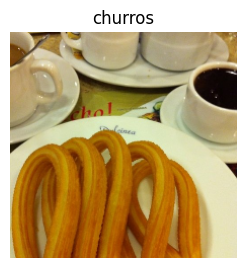

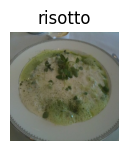

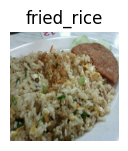

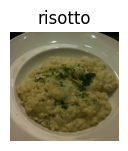

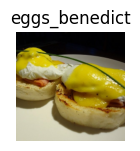

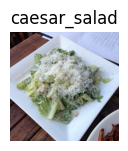

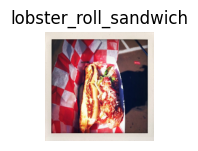

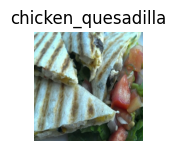

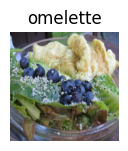

In [6]:
for image, labels in ds_train.take(1):
  plt.figure(figsize=(10,10))
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy())
    label = ds_info.features['label'].int2str(labels[i].numpy())
    plt.title(label)
    plt.axis('off')
    plt.show()

In [7]:
# STEP 7: Build the CNN Model (Transfer Learning)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False # Freeze base layers

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(), # Flatten feature maps
    tf.keras.layers.Dense(101, activation='softmax') # 101 food categories
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )


In [9]:
history = model.fit(ds_train, epochs=1, validation_data=ds_test)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 4606s 2s/step - accuracy: 0.3793 - loss: 2.6170 - val_accuracy: 0.5748 - val_loss: 1.6190


In [10]:
#STEP 10: Evaluate the Model
loss, accuracy = model.evaluate(ds_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

790/790 ━━━━━━━━━━━━━━━━━━━━ 1162s 1s/step - accuracy: 0.5771 - loss: 1.6164
Test Accuracy: 57.48%


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


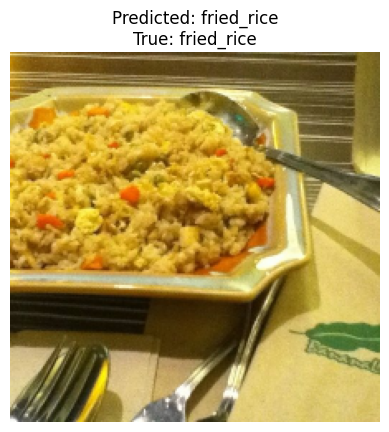

In [11]:
#STEP 11: Make Predictions & Show Results
class_names = ds_info.features['label'].names

for images, labels in ds_test.take(1):
    image = images[0]
    true_label = class_names[labels[0].numpy()]

    prediction = model.predict(tf.expand_dims(image, axis=0))
    predicted_label = class_names[np.argmax(prediction)]

    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis('off')
    plt.show()

In [12]:
#STEP 12: Save the Trained Model (Optional)
model.save("food101_model.h5")  # Save to file
#Saves the trained model in .h5 format so you can reuse it later.+